In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
%matplotlib inline

# Grid model : PI, VI and Q-learning

This document illustrates a few algorithms (PI, VI and Q-learning) on a simple 2D grid examples. 

**WARNING** the code is made slow (and sometimes a bit ugly) because of the various functions that are used for plotting the results. 

## Model

There is a grid N x N. 

Actions = we choose one direction. 

We go to this direction with probability p, to a random position among 4 with probability (1-p)/4. If the move is not possible, we do not move. 

In [2]:
def print_grid(grid, position, objective,trap):
    N = len(grid)
    print('+',end='');print(''.join(['-' for i in range(N)]),end='');print('+')
    for i in range(N):
        print('|',end='')
        for j in range(N):
            if grid[i,j] == 0:
                if position[0] == i and position[1] == j:
                    if position[0] == objective[0] and position[1] == objective[1]:
                        print('X',end='')
                    else:
                        print('x',end='')
                elif objective[0] == i and objective[1] == j:
                    print('O',end='')
                elif trap[0]==i and trap[1] == j:
                    print('T',end='')
                else:
                    print(' ',end='')
            else:
                print('#',end='')
        print('|')
    print('+',end='');print(''.join(['-' for i in range(N)]),end='');print('+')


In [3]:
N=10
grid = np.zeros((N,N))
for i in range(6): grid[3,i] = 1
p = .7

objective = [5,0]
trap = [5,4]
position = [0,0]
print_grid(grid,position,objective,trap)

+----------+
|x         |
|          |
|          |
|######    |
|          |
|O   T     |
|          |
|          |
|          |
|          |
+----------+


In [4]:
def is_valid(grid,position):
    return (position[0] < N and position[0] >= 0 and 
            position[1] < N and position[1] >= 0 and 
            grid[position[0],position[1]] == 0)

def next_position(grid,position,action,p):
    moves = [[1,0],[0,1],[-1,0],[0,-1]]
    if np.random.rand() < (1-p): action = np.random.randint(4)
    new_position = [position[0]+moves[action][0], position[1]+moves[action][1]]
    if is_valid(grid,new_position):
        return new_position
    else:
        return position
next_position(grid,[0,0],2,0.5)

[0, 0]

In [5]:
def simulate(grid,origin,objective,strategy,p,max_number_of_moves = 10000):
    position = origin
    number_of_moves = 0
    while number_of_moves < max_number_of_moves:
        if position[0] != objective[0] or position[1] != objective[1]:
            position = next_position(grid, position, strategy[tuple(position)],p)
        else:
            break
        number_of_moves += 1
    return number_of_moves

In [6]:
strategy = np.array([[np.random.randint(4) for i in range(N)] for j in range(N)])
simulate(grid,[0,0],[5,5],strategy, .5)

10000

## Policy and Value iteration

In [7]:
def nextMove(position, move):
    new_position = [position[0]+move[0], position[1]+move[1]]
    if is_valid(grid,new_position):
        return new_position
    else:
        return position
def isTrap(i,j):
    return i == trap[0] and j == trap[1]
def isObjective(i,j):
    return i == objective[0] and j == objective[1]
def updateLineOfPAction(P,i,j,action):
    moves = [[1,0],[0,1],[-1,0],[0,-1],[0,0]]
    if action < 4 and not (isTrap(i,j) or isObjective(i,j)):
        for possibleMove in range(4):
            [newI,newJ] = nextMove([i,j],moves[possibleMove])
            P[i,j,newI,newJ] += (1-p)/4
            if action == possibleMove:
                P[i,j,newI,newJ] += p
    else:
        P[i,j,i,j] = 1
def P_a(action): # transitions matrix corresponding to one of the actions
    P = np.zeros((N,N,N,N))
    for i in range(N):
        for j in range(N):
            updateLineOfPAction(P,i,j,action)
    return np.matrix(P.reshape((N**2,N**2)))
def P_pi(pi):
    ''' This is a transition matrix corresponding to the strategy pi'''
    P = np.zeros((N,N,N,N))
    pi2d = pi.reshape((N,N))
    for i in range(N):
        for j in range(N):
            updateLineOfPAction(P,i,j,pi2d[i,j])
    return np.matrix(P.reshape((N**2,N**2)))

def cost():
    V2d = np.ones((N,N))
    V2d[objective[0],objective[1]] = 0
    V2d[trap[0],trap[1]] = 2
    return(V2d.reshape((N**2)))

def pi_V(V):
    C = cost()
    newV = np.array([C+delta*np.tensordot(P_a(action),V,1) for action in range(4)])
    return np.argmin(newV,0)


+--------------------------------------------------------------------------------+
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|################################################   0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
|   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 |
+--------------------------------------------------------------------------------+
|   

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

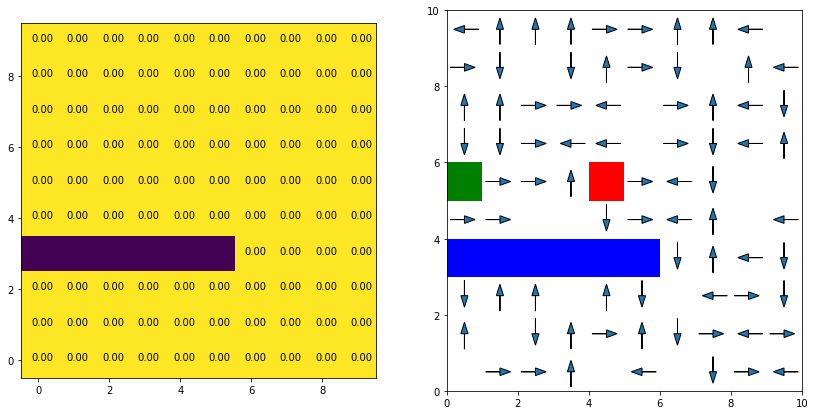

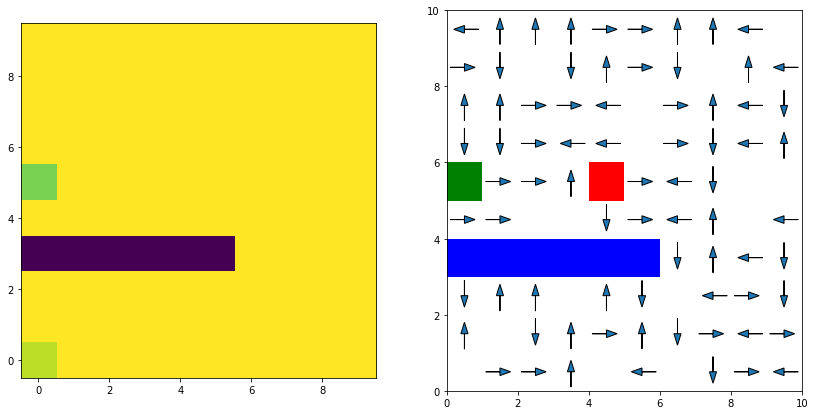

In [8]:
def print_valueFunction(V):
    N = len(grid)
    V2d = V.reshape((N,N))
    print('+',end='');print(''.join(['--------' for i in range(N)]),end='');print('+')
    for i in range(N):
        print('|',end='')
        for j in range(N):
            if grid[i,j] == 0:
                print('{0:7.2f} '.format(V2d[i,j]),end='')
            else:
                print('########',end='')
        print('|')
V = np.zeros((N*N))
print_valueFunction(V)
print_valueFunction(cost())

def plot_valueFunction(V,pi,print_text=True,save_as=None):
    vmax=20
    vmin=0
    V2d = V.reshape((N,N))
    for i in range(N):
        for j in range(N):
            if grid[i,j] != 0:  V2d[i,j] = vmax
    f = plt.figure()
    f.set_size_inches(14,7)
    plt.subplot(1,2,1)
    plt.imshow(-V2d,vmin=-vmax,vmax=-vmin,origin='lower')
    if print_text:
        for i in range(N): 
            for j in range(N):
                if grid[i,j]==0:
                    plt.text(j-0.2,i,'{0:1.2f}'.format(V2d[i,j]))
    ax=plt.subplot(1,2,2)
    pi2d=pi.reshape((N,N))
    dx = [.4,0,-.4,0,0]
    dy = [0,.4,0,-.4,0]
    for i in range(10):
        for j in range(10):
            if isTrap(i,j):
                rect=patches.Rectangle((j,i),1,1,facecolor='r',fill=True)
                ax.add_patch(rect)
            elif isObjective(i,j):
                rect=patches.Rectangle((j,i),1,1,facecolor='g',fill=True)
                ax.add_patch(rect)
            elif grid[i,j] == 0:  
                x = dx[pi2d[i,j]]
                y = dy[pi2d[i,j]]
                if pi2d[i,j] != 4: plt.arrow(j-y+0.5,i-x+0.5,y,x,head_width=0.2)    
            else:
                rect=patches.Rectangle((j,i),1,1,facecolor='b',fill=True)
                ax.add_patch(rect)
    plt.xlim(0,10)
    plt.ylim(0,10)
    if not save_as is None:
        f.savefig(save_as,bbox_inches='tight')

label_action = ['  S  ','  E  ','  N  ','  W  ','  -  ']
def print_policy(pi):
    N = len(grid)
    pi2d = pi.reshape((N,N))
    print('+',end='');print(''.join(['------' for i in range(N)]),end='');print('+')
    for i in range(N):
        print('|',end='')
        for j in range(N):
            if grid[i,j] == 0:
                print(label_action[int(pi2d[i,j])],end=' ')
            else:
                print('######',end='')
        print('|')
        
pi = np.array([int(np.random.randint(5)) for i in range(N**2)])
print_policy(pi)
#plot_policy(pi)

pos = np.zeros(N**2)
print_valueFunction(pos*P_a(1))
f=plot_valueFunction(pos*P_a(1),pi)
pos[0] = 2
pos[50] = 4

plot_valueFunction(pos,pi,print_text=False)
delta=0.95
pi_V(pos)

number of iterations: 181
+--------------------------------------------------------------------------------+
|  15.49   15.20   14.87   14.51   14.14   13.74   13.36   13.62   14.02   14.32 |
|  15.29   14.97   14.60   14.20   13.77   13.31   12.84   13.18   13.62   13.97 |
|  15.08   14.72   14.31   13.85   13.36   12.82   12.23   12.66   13.15   13.56 |
|################################################  11.54   12.11   12.65   13.12 |
|   1.38    2.59    3.78    5.31    9.13   10.09   10.85   11.52   12.14   12.66 |
|   0.00    1.62    3.25    7.02   40.00   12.28   10.86   11.36   11.92   12.42 |
|   1.51    2.80    4.06    5.58    9.16    9.42   10.06   10.75   11.39   11.94 |
|   2.90    4.00    5.11    6.19    7.38    8.39    9.30   10.13   10.87   11.50 |
|   4.17    5.11    6.13    7.08    7.97    8.82    9.61   10.34   11.02   11.60 |
|   5.25    6.06    6.95    7.79    8.58    9.32   10.02   10.68   11.30   11.83 |
+------------------------------------------------------------

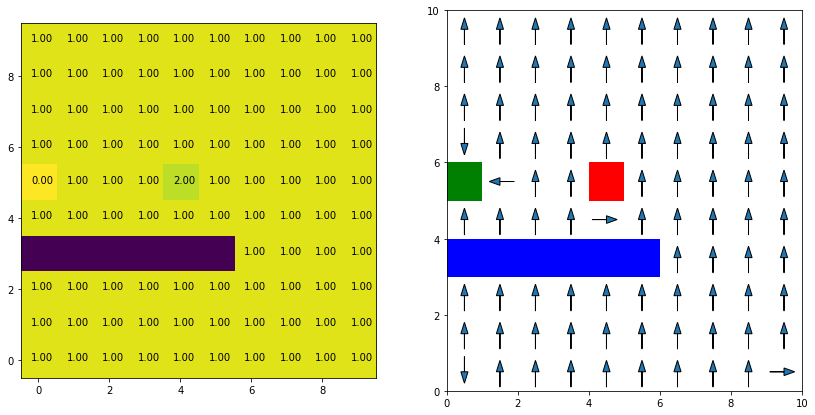

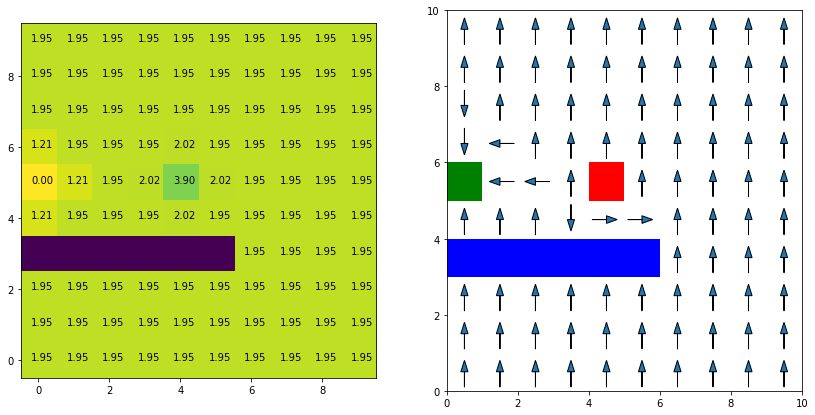

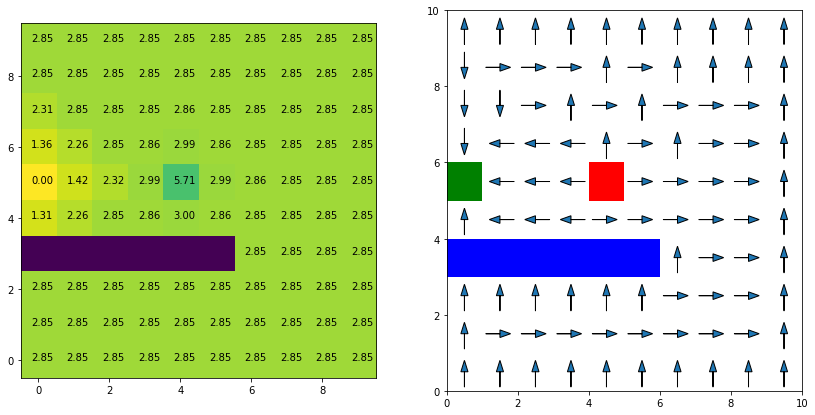

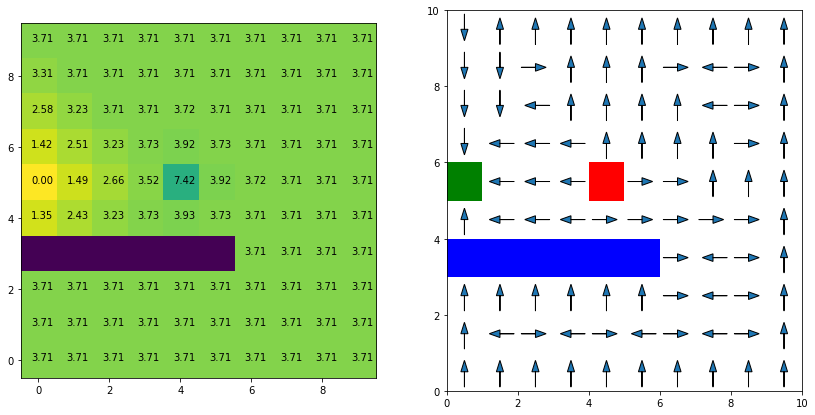

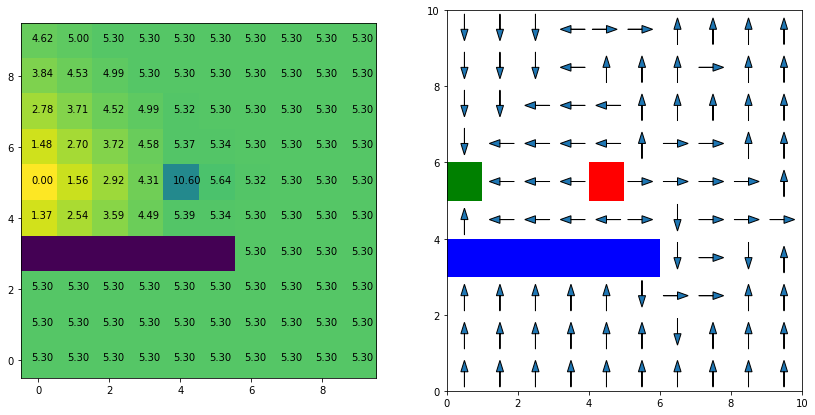

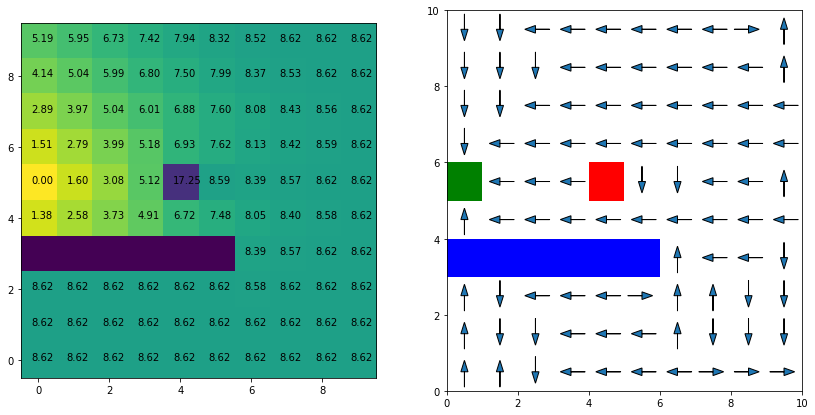

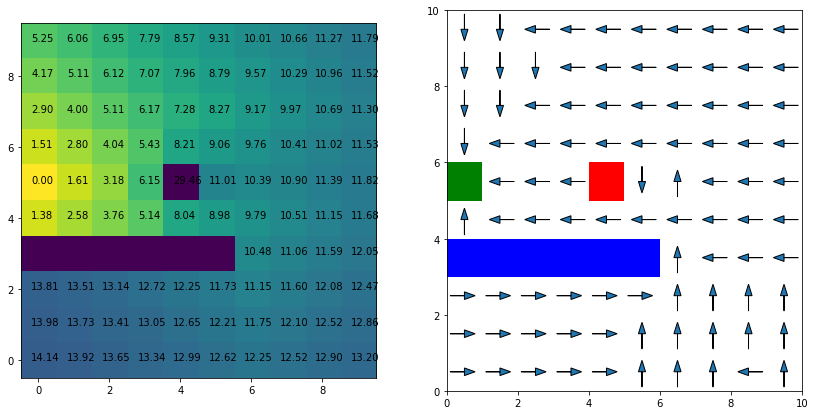

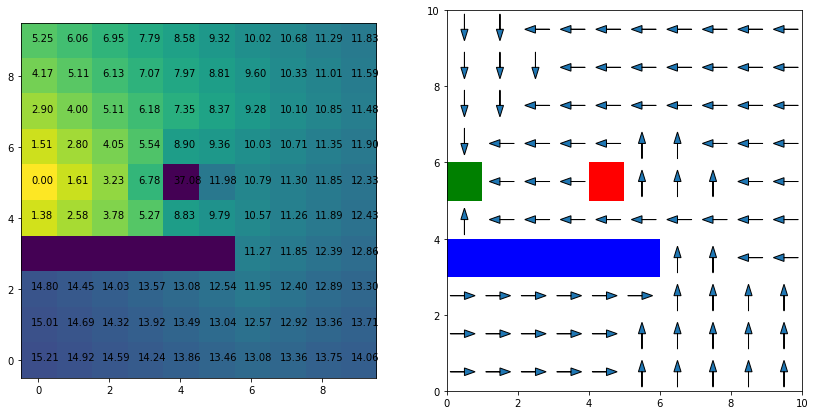

In [22]:
objective = [5,0]
delta=0.95
p=0.7
def valueIteration(doPrint=False,doSave=None):
    C = cost()
    V = C
    oldV = V
    for i in range(1000):
        pi = pi_V(V)
        if not doSave is None and i in doSave:
            plot_valueFunction(V,pi,save_as='gridValueIteration_{}.pdf'.format(i))
        #print(pi)
        V = C + delta*np.tensordot(P_pi(pi),V,1)
        if (doPrint): 
            print('Iteration:',i)
            print_policy(pi)
            print_valueFunction(V)
        deltaV = np.sum(np.abs(V-oldV))
        if deltaV < 1e-3: break
        oldV = V
    print('number of iterations:',i)
    return V,pi
V,pi = valueIteration(doPrint=False,doSave=[0,1,2,3,5,10,25,50])
print_valueFunction(V)
print_policy(pi)

1832.1481517152897
441.88864094527776
513.5882374061074
71.78820718151016
55.49146652783433
53.01262014140719
0.0
number of iterations: 6
+--------------------------------------------------------------------------------+
|  15.49   15.20   14.87   14.51   14.14   13.74   13.36   13.62   14.02   14.32 |
|  15.29   14.97   14.60   14.20   13.77   13.31   12.84   13.18   13.62   13.97 |
|  15.08   14.72   14.31   13.85   13.36   12.82   12.23   12.66   13.15   13.56 |
|################################################  11.54   12.11   12.65   13.12 |
|   1.38    2.59    3.78    5.31    9.13   10.09   10.85   11.52   12.14   12.66 |
|  -0.00    1.62    3.25    7.02   40.00   12.28   10.86   11.36   11.92   12.42 |
|   1.51    2.80    4.06    5.58    9.16    9.42   10.06   10.75   11.39   11.94 |
|   2.90    4.00    5.11    6.19    7.38    8.39    9.30   10.13   10.87   11.50 |
|   4.17    5.11    6.13    7.08    7.97    8.82    9.61   10.34   11.02   11.60 |
|   5.25    6.06    6.95    7.79

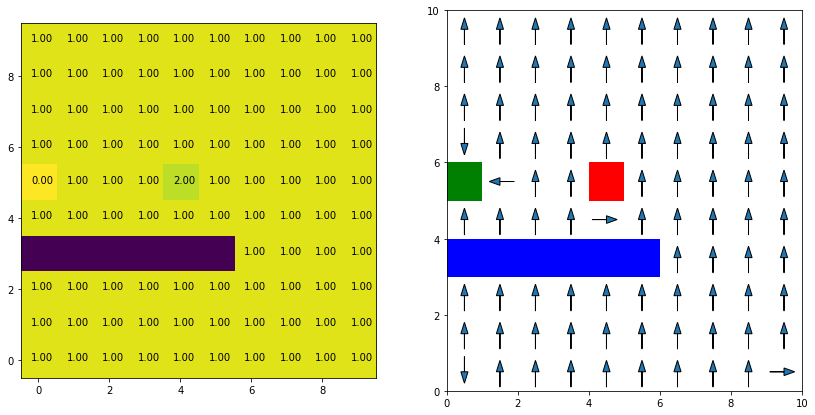

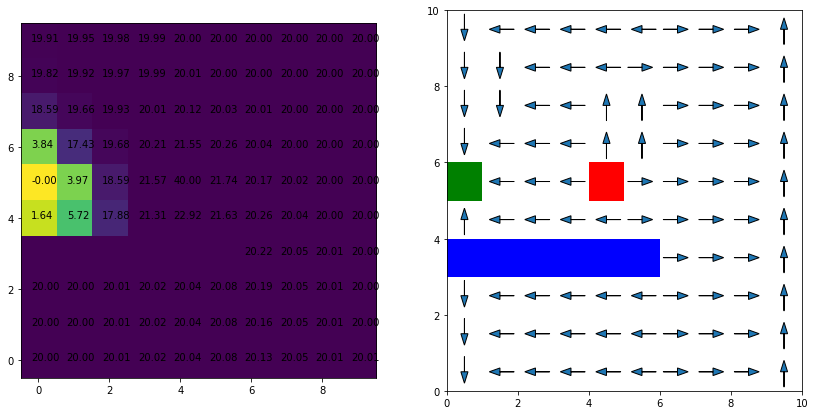

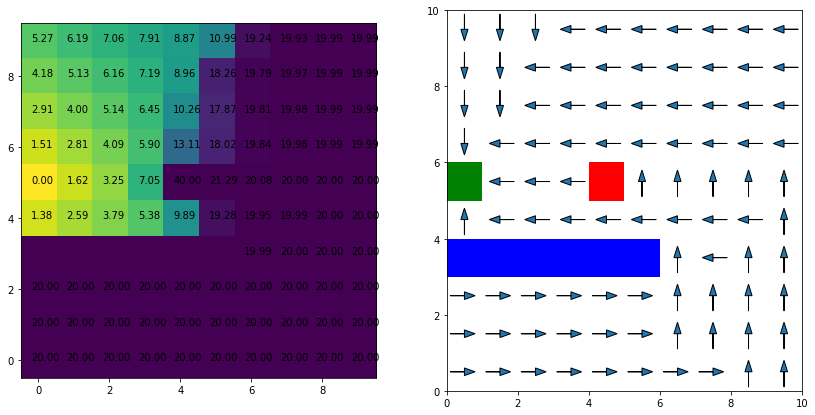

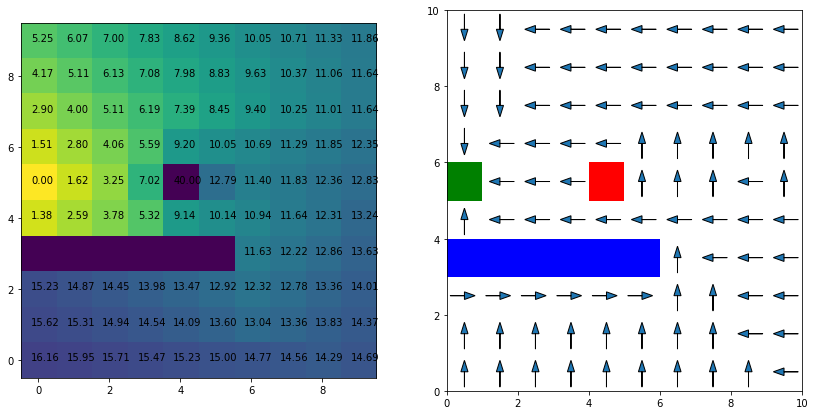

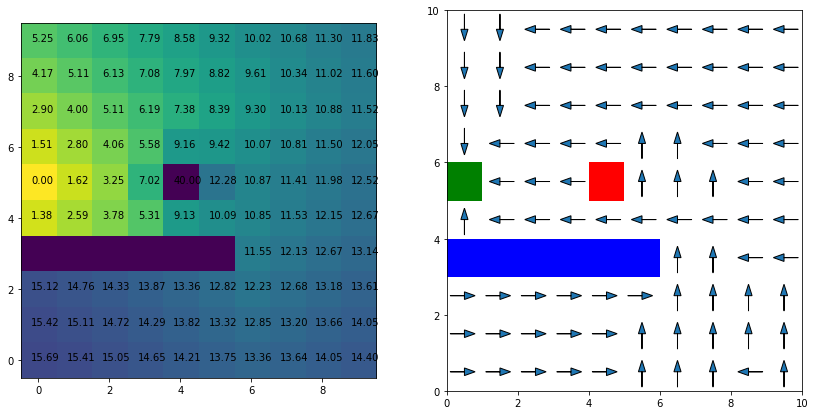

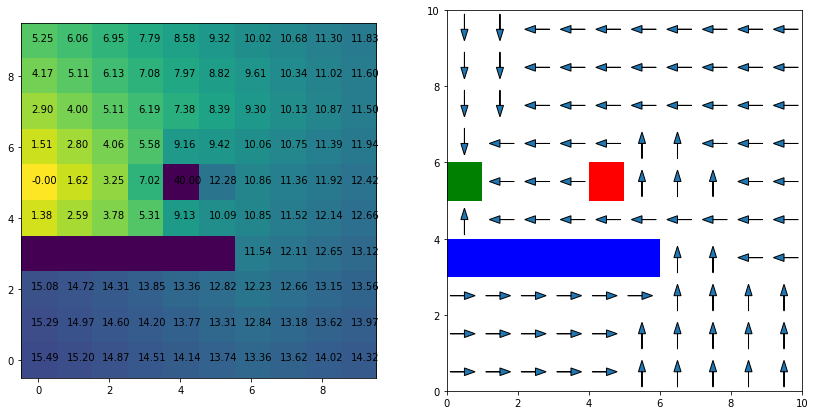

In [10]:
#delta=0.999
def policyIteration(doPrint=False,doSave=None):
    C = cost()
    V = C
    oldV = V
    for i in range(1000):
        pi = pi_V(V)
        if not doSave is None and i in doSave:
            plot_valueFunction(V,pi,save_as='gridPolicyIteration_{}.pdf'.format(i))
        V = np.tensordot(np.linalg.inv(np.eye(N**2)-delta*P_pi(pi)),C,1)
        if (doPrint): 
            print('Iteration:',i)
            print_valueFunction(V)
        deltaV = np.sum(np.abs(V-oldV))
        print(deltaV)
        if deltaV <= 1e-10: break # not 0 because of floating point errors
        oldV = V
    print('number of iterations:',i)
    return V,pi
V,pi = policyIteration(doPrint=False,doSave=[0,1,2,3,4,5])
print_valueFunction(V)
print_policy(pi)


## $Q$-learning

70000

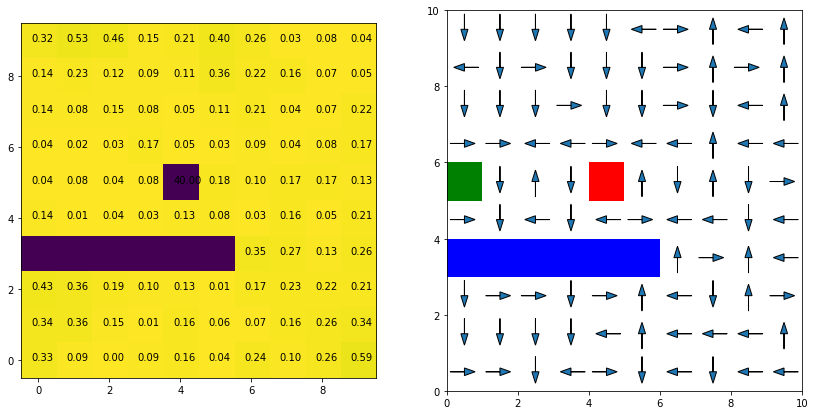

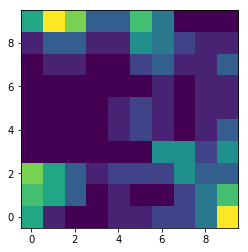

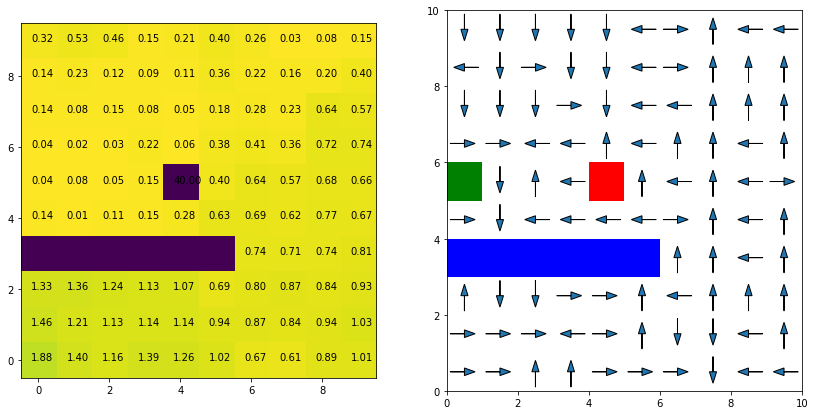

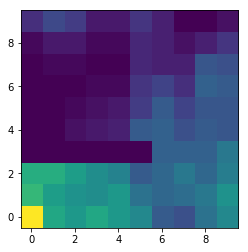

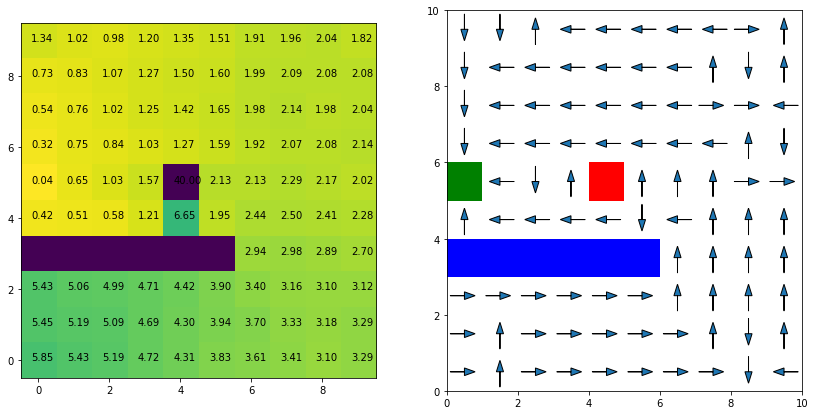

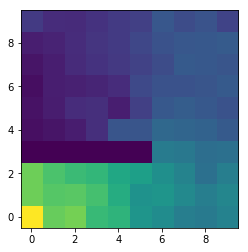

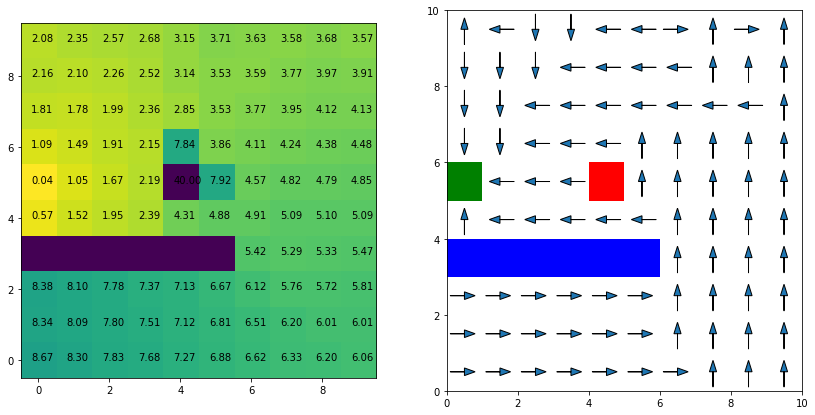

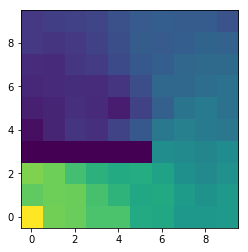

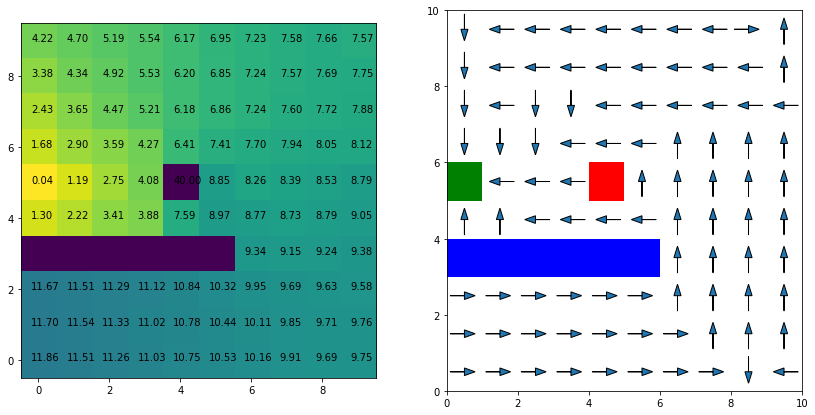

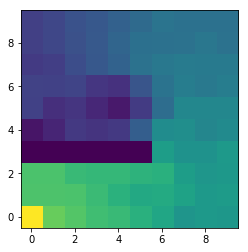

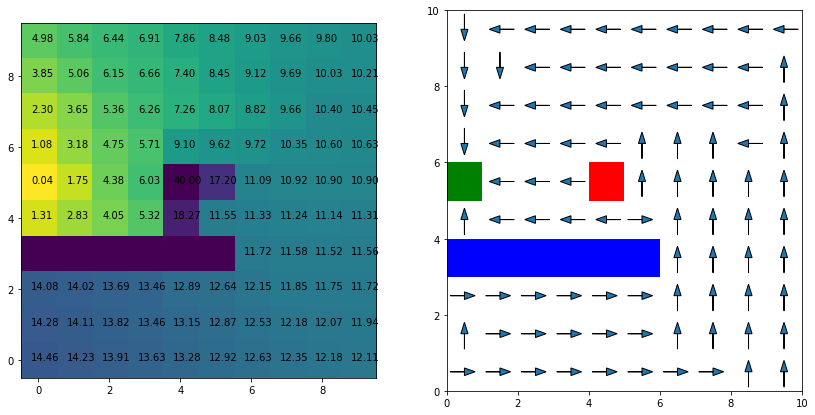

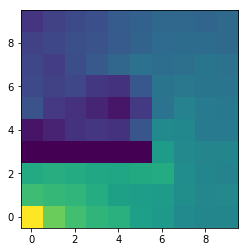

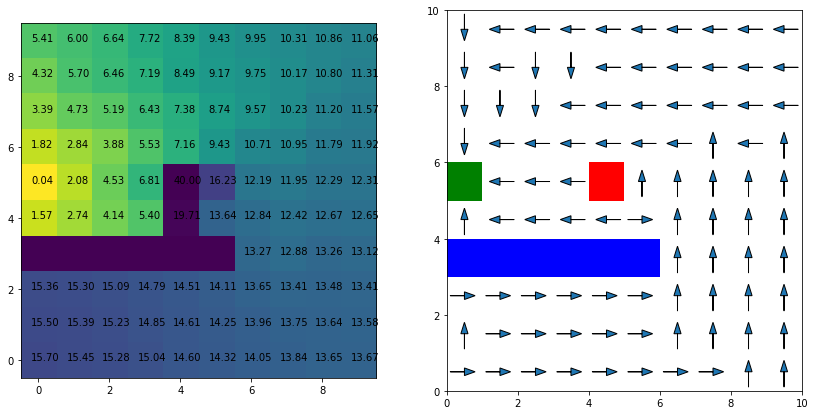

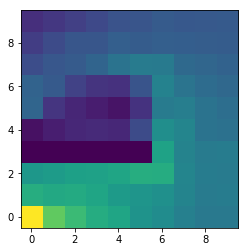

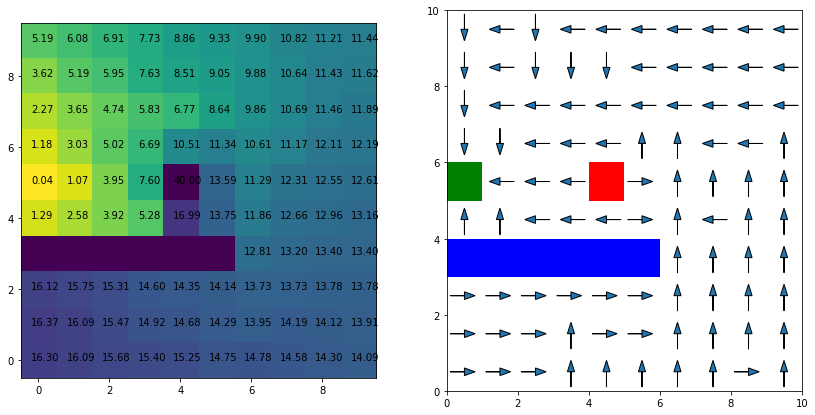

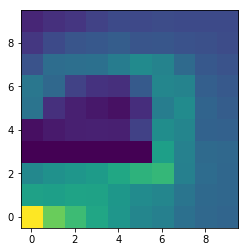

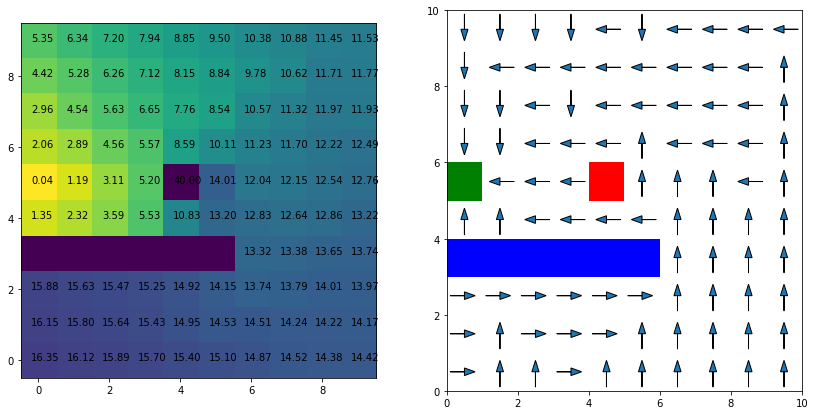

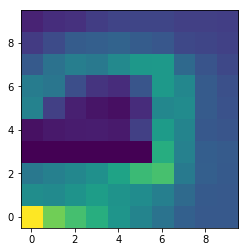

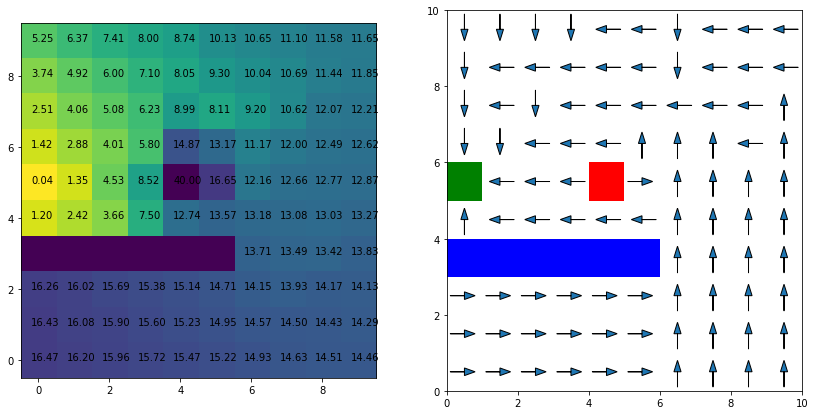

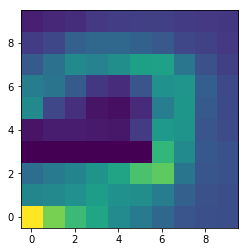

In [11]:
myP = [np.array(P_a(action)) for action in range(5)]
def oneStep(i,action):
    return np.random.choice(range(N**2),p=myP[action][i,:])

objc_1D = np.ravel_multi_index((objective[0],objective[1]), (N,N))
trap_1D = np.ravel_multi_index((trap[0],trap[1]), (N,N))
Q = np.random.rand(N**2,4)/4
C = cost()
Vtime = []

def Qaction(i,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.randint(4)
    else:
        return np.argmin(Q[i,:])

def Qlearning(i,alpha,epsilon):
    if i == objc_1D:
        return 0
    elif i == trap_1D:
        for j in range(4): Q[i,j] = 2/(1-delta)
        return 0
    action = Qaction(i,epsilon)
    j = oneStep(i,action)
    Q[i,action] += alpha * (C[i] + delta*min(Q[j,:])-Q[i,action])
    return j

i = 0
myI = []
myQ = []
savePoints = [200,1000,5000,10000,20000,30000,40000,50000,60000,70000]
for j in range(70001):
    i = Qlearning(i,0.2,.1)
    myI.append(i)
    if j%50 == 0:
        V = np.min(Q,1)
        pi = pi_V(V)
        if j in savePoints : 
            plot_valueFunction(V,pi,save_as='gridQlearning_{}.pdf'.format(j))
            f = plt.figure()
            plt.imshow(np.bincount(myI,minlength=N**2).reshape((N,N)),origin='lower')
            f.savefig('gridQlearningVisitedStates_{}.pdf'.format(j),bbox_inches='tight')
        myQ.append(V)
        print('\r{}'.format(j),end='')

In [12]:
V = np.min(Q,1)
print_valueFunction(V)
print_policy(pi_V(V))

+--------------------------------------------------------------------------------+
|  16.47   16.20   15.96   15.72   15.47   15.22   14.93   14.63   14.51   14.46 |
|  16.43   16.08   15.90   15.60   15.23   14.95   14.57   14.50   14.43   14.29 |
|  16.26   16.02   15.69   15.38   15.14   14.71   14.15   13.93   14.17   14.13 |
|################################################  13.71   13.49   13.42   13.83 |
|   1.20    2.42    3.66    7.50   12.74   13.57   13.18   13.08   13.03   13.27 |
|   0.04    1.35    4.53    8.52   40.00   16.65   12.16   12.66   12.77   12.87 |
|   1.42    2.88    4.01    5.80   14.87   13.17   11.17   12.00   12.49   12.62 |
|   2.51    4.06    5.08    6.23    8.99    8.11    9.20   10.62   12.07   12.21 |
|   3.74    4.92    6.00    7.10    8.05    9.30   10.04   10.69   11.44   11.85 |
|   5.25    6.37    7.41    8.00    8.74   10.13   10.65   11.10   11.58   11.65 |
+------------------------------------------------------------+
|  E     E     E     E  

In [13]:
V_PI,pi_PI=policyIteration()
print_valueFunction(V_PI)
print_policy(pi_PI)

1814.9033753967635
379.69469444822874
491.62605096910795
18.87690286452703
2.496608121251362
0.007380967988012073
0.0
number of iterations: 6
+--------------------------------------------------------------------------------+
|  15.49   15.20   14.87   14.51   14.14   13.74   13.36   13.62   14.02   14.32 |
|  15.29   14.97   14.60   14.20   13.77   13.31   12.84   13.18   13.62   13.97 |
|  15.08   14.72   14.31   13.85   13.36   12.82   12.23   12.66   13.15   13.56 |
|################################################  11.54   12.11   12.65   13.12 |
|   1.38    2.59    3.78    5.31    9.13   10.09   10.85   11.52   12.14   12.66 |
|  -0.00    1.62    3.25    7.02   40.00   12.28   10.86   11.36   11.92   12.42 |
|   1.51    2.80    4.06    5.58    9.16    9.42   10.06   10.75   11.39   11.94 |
|   2.90    4.00    5.11    6.19    7.38    8.39    9.30   10.13   10.87   11.50 |
|   4.17    5.11    6.13    7.08    7.97    8.82    9.61   10.34   11.02   11.60 |
|   5.25    6.06    6.95    

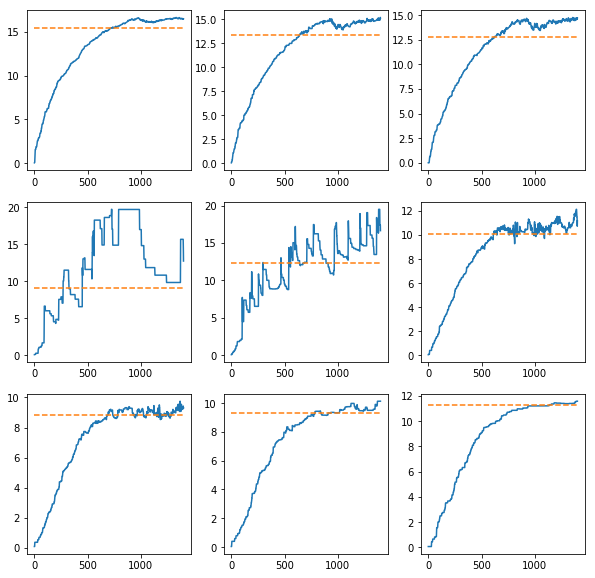

In [14]:
Qtime = np.array(myQ)
f=plt.figure()
f.set_size_inches(10,10)
for (ifig,position) in enumerate([0,24,25,44,55,66,85,95,98]):
    plt.subplot(3,3,ifig+1)
    plt.plot(Qtime[:,position])
    plt.plot([0,len(Qtime)],[V_PI[position],V_PI[position]],'--')
#plt.ylim([1,1.3])

(array([2222., 1764., 1518., 1311., 1076.,  918.,  743.,  589.,  539.,
         530., 1017., 1049., 1127., 1238., 1125., 1102.,  935.,  682.,
         553.,  536.,  803.,  910., 1005., 1147., 1297., 1580., 1671.,
         861.,  591.,  556.,    0.,    0.,    0.,    0.,    0.,    0.,
        1467., 1052.,  611.,  563.,  121.,  168.,  178.,  159.,  141.,
         383., 1194., 1153.,  588.,  519., 1059.,  473.,  301.,  119.,
          90.,  265.,  952., 1172.,  633.,  496.,  945.,  854.,  631.,
         358.,  282.,  586., 1123., 1161.,  662.,  493.,  626.,  830.,
        1052.,  981., 1096., 1260., 1268.,  876.,  554.,  421.,  385.,
         481.,  683.,  738.,  751.,  686.,  618.,  476.,  441.,  372.,
         191.,  254.,  288.,  372.,  403.,  419.,  421.,  383.,  372.,
         356.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.

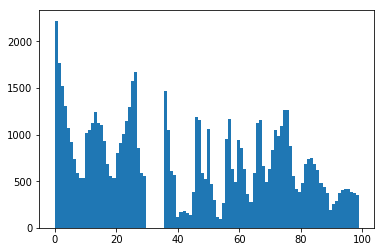

In [15]:
plt.hist(myI,bins=100)

## Sarsa

In [16]:
Q = np.random.rand(N**2,5)/5
C = cost() 
Vtime = []

def sarsa(i,action,alpha,epsilon):
    if i == objc_1D:
        Q[i,4] = 0
        return (0,Qaction(0,epsilon))
    j = oneStep(i,action)
    nextAction = Qaction(j,epsilon)
    Q[i,action] += alpha * (C[i] + delta*Q[j,nextAction]-Q[i,action])
    return j,nextAction

i = 0
action = np.random.randint(5)
myI = []
myActions = []
for j in range(100000):
    #print(sarsa(i,action,0.1,0.1))
    i,action = sarsa(i,action,0.1,0.1)
    myI.append(i)
    myActions.append(action)

In [17]:
V = np.min(Q,1)
print_valueFunction(V)
print_policy(pi_V(V))

+--------------------------------------------------------------------------------+
|   0.18    0.19    0.20    0.17    0.01    0.04    0.16    0.23    0.27    0.20 |
|   0.11    0.16    0.02    0.01    0.08    0.10    0.12    0.21    0.26    0.23 |
|   0.04    0.11    0.02    0.00    0.08    0.12    0.21    0.14    0.37    0.30 |
|################################################   0.21    0.25    0.33    0.26 |
|   0.03    0.08    0.06    0.06    0.08    0.06    0.14    0.20    0.23    0.20 |
|   0.02    0.02    0.07    0.02   40.00    0.13    0.06    0.16    0.13    0.06 |
|   0.00    0.01    0.01    0.04    0.00    0.14    0.16    0.13    0.03    0.00 |
|   0.04    0.03    0.07    0.02    0.08    0.09    0.15    0.18    0.18    0.12 |
|   0.08    0.11    0.08    0.05    0.15    0.07    0.28    0.28    0.20    0.08 |
|   0.07    0.04    0.02    0.00    0.19    0.24    0.20    0.23    0.33    0.26 |
+------------------------------------------------------------+
|  S     S     S     E  

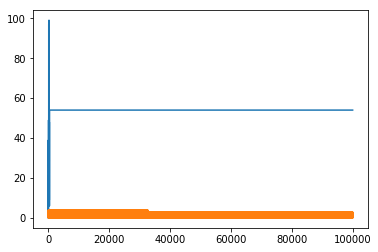

In [18]:
plt.plot(myI)
plt.plot(myActions)

# Cliff example

In [19]:
actions = [[-1,0],[0,-1],[1,0],[0,1]]
Xmax = 12
Ymax = 4
def nextState( xy, action):
    [i,j] = xy
    if j == 0 and i != 0 : return [0,0]
    x = i+actions[action][0]
    y = j+actions[action][1]
    return [max(min(x,Xmax),0),max(min(y,Ymax),0)]
def epsilonGreedy(Qs,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.randint(4)
    else:
        Qrandomized = Qs+np.random.rand(4)*1e-6
        return np.argmax(Qrandomized)
def cost_cliff():
    C = -np.ones((Xmax+1,Ymax+1))
    C[:,0] = -100
    C[Xmax,0] = 0
    return C

def Qlearning(alpha,epsilon):
    Q = np.zeros((Xmax+1,Ymax+1,4))
    S = [0,0]
    C = cost_cliff()
    for i in range(100000):
        A = epsilonGreedy(Q[S[0],S[1],:],epsilon)
        Sp = nextState(S,A)
        if S[1] != 0 or S[0] == 0:
            Q[S[0],S[1],A] = Q[S[0],S[1],A] + alpha* (
                C[Sp[0],Sp[1]] + max(Q[Sp[0],Sp[1],:]) - Q[S[0],S[1],A] )
        S = Sp
    return Q

def SARSA(alpha,epsilon):
    Q = np.zeros((Xmax+1,Ymax+1,4))
    S = [0,0]
    A = epsilonGreedy(Q[S[0],S[1],:],epsilon)
    C = cost_cliff()
    for i in range(100000):
        Sp = nextState(S,A)
        Ap = epsilonGreedy(Q[Sp[0],Sp[1],:],epsilon)
        if S[1] != 0 or S[0] == 0:
            Q[S[0],S[1],A] = Q[S[0],S[1],A] + alpha* (
                C[Sp[0],Sp[1]] + Q[Sp[0],Sp[1],Ap] - Q[S[0],S[1],A] )
        S = Sp
        A = Ap
    return Q

In [20]:
Q_sarsa = SARSA(0.1,0.1)

In [21]:
print(np.max(Q_sarsa,2))

[[-21.09046767 -18.30970824 -16.55463801 -15.43667571 -15.01261427]
 [  0.         -15.67587432 -14.57781359 -14.2896168  -14.2662143 ]
 [  0.         -14.59546028 -13.47166725 -13.2586469  -13.37507605]
 [  0.         -13.25910144 -12.54341451 -12.23226968 -12.47331629]
 [  0.         -12.22299659 -11.08326358 -11.24181206 -11.50451456]
 [  0.         -10.86036275  -9.75925546 -10.10280746 -10.52324701]
 [  0.          -9.82995681  -8.09242358  -8.98936895  -9.53486472]
 [  0.          -8.50013529  -7.001764    -7.85870884  -8.52376524]
 [  0.          -7.13752015  -6.09563932  -6.70364184  -7.55339688]
 [  0.          -5.92047322  -4.65175799  -5.60211928  -6.57483957]
 [  0.          -4.66432992  -3.62921538  -4.60473543  -5.52832334]
 [  0.          -1.39176681  -2.42069064  -3.53192025  -4.4999015 ]
 [  0.           0.          -1.01374606  -2.12967153  -3.39057816]]
